> This is a self-correcting activity generated by [nbgrader](https://nbgrader.readthedocs.io). Fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. Run subsequent cells to check your code.

---

# Classify fashion items

[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) is analogous to the MNIST handwritten digits dataset. It consists of 60,000 28x28 grayscale images (pixel values between 0 and 255) of 10 fashion categories, along with a test set of 10,000 images. The goal here is to associate a fashion image with its class.

![Fasion items](images/fashion-mnist-sprite.png)

Each training and test example is assigned to one of the following label (fashion category):

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

## Environment setup

In [1]:
# Import base packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# Setup plots
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8
%config InlineBackend.figure_format = 'retina'
sns.set()

In [3]:
# Import ML packages
import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')
print(f'Keras version: {tf.keras.__version__}')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import fashion_mnist # Added in Keras 2.0.9
from tensorflow.keras.utils import to_categorical

TensorFlow version: 2.3.1
Keras version: 2.4.0


## Utility functions

In [4]:
def plot_loss_acc(history):
    """Plot training and (optionally) validation loss and accuracy"""

    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss, '.--', label='Training loss')
    final_loss = loss[-1]
    title = 'Training loss: {:.4f}'.format(final_loss)
    plt.ylabel('Loss')
    if 'val_loss' in history.history:
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, 'o-', label='Validation loss')
        final_val_loss = val_loss[-1]
        title += ', Validation loss: {:.4f}'.format(final_val_loss)
    plt.title(title)
    plt.legend()

    acc = history.history['accuracy']

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, '.--', label='Training acc')
    final_acc = acc[-1]
    title = 'Training accuracy: {:.2f}%'.format(final_acc * 100)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    if 'val_accuracy' in history.history:
        val_acc = history.history['val_accuracy']
        plt.plot(epochs, val_acc, 'o-', label='Validation acc')
        final_val_acc = val_acc[-1]
        title += ', Validation accuracy: {:.2f}%'.format(final_val_acc * 100)
    plt.title(title)
    plt.legend()

## Step 1: loading the data

### Question

Load the Fashion-MNIST dataset included with Keras. Use variables named `train_images`, `train_labels`, `test_images` and `test_labels` to store the data.

In [9]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [10]:
print(f'Training images: {train_images.shape}. Training labels: {train_labels.shape}')
print(f'Training labels: {train_labels}')
assert train_images.shape == (60000, 28, 28)
assert train_labels.shape == (60000, )
assert test_images.shape == (10000, 28, 28)
assert test_labels.shape == (10000, )

Training images: (60000, 28, 28). Training labels: (60000,)
Training labels: [9 0 0 ... 3 0 5]


### Question

Display the first 10 test images.

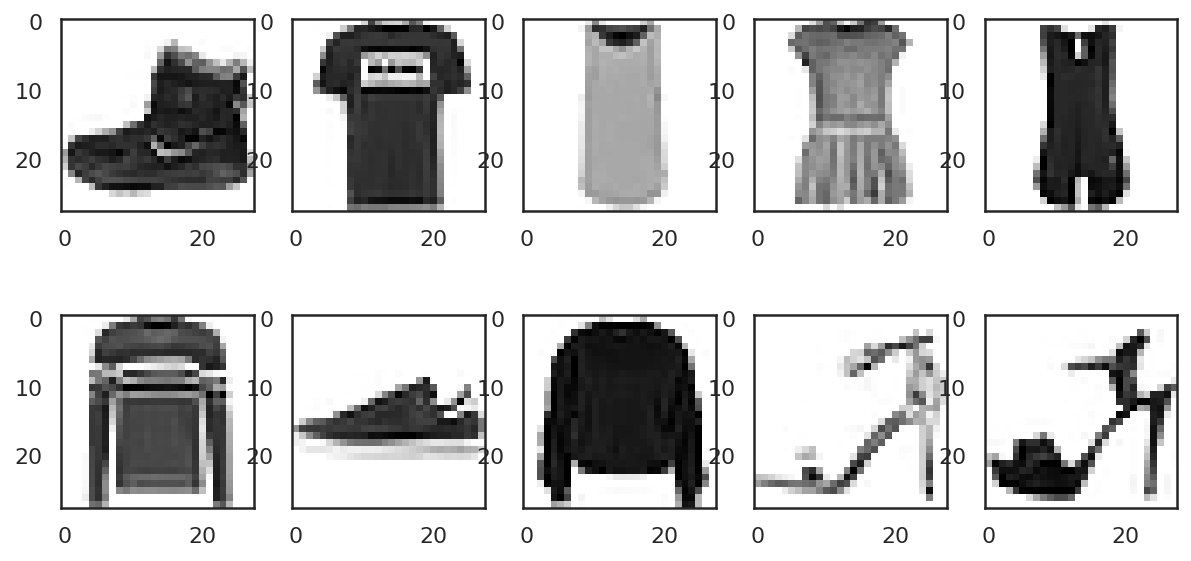

In [12]:
# Plot the first 10 digits
with sns.axes_style("white"):  # Temporary hide Seaborn grid lines
    plt.figure(figsize=(10, 5))
    for i in range(10):
        image = train_images[i]
        fig = plt.subplot(2, 5, i + 1)
        plt.imshow(image, cmap=plt.cm.binary)

## Step 2: preparing the data

### Question

Create variables `x_train` and `x_test` from training and test images, with appropriate rescaling.

In [13]:
x_train = train_images.astype('float32') / 255
x_test = test_images.astype('float32') / 255

In [14]:
print(f'x_train: {x_train.shape}. x_test: {x_test.shape}')

# Assert tensors shapes
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)

# Assert tensors values
assert (np.amin(x_train, axis=0) >= 0).all() and (np.amax(x_train, axis=0) <= 1).all()
assert (np.amin(x_test, axis=0) >= 0).all() and (np.amax(x_test, axis=0) <= 1).all()

x_train: (60000, 28, 28). x_test: (10000, 28, 28)


### Question

One-hot encode training and test targets into variables `y_train` and `y_test`.

In [15]:
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

In [16]:
# Show a sample of encoded targets
df_y_train = pd.DataFrame(y_train)
df_y_train.sample(n=10)

,0,1,2,3,4,5,6,7,8,9
53056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
24732,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2568,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
25311,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
48061,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8588,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58125,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
13047,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
17367,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
23166,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [17]:
print(f'y_train: {y_train.shape}. y_test: {y_test.shape}')

# Assert one-hot encoding of training and test targets
assert y_train.shape == (60000, 10)
assert y_test.shape == (10000, 10)

# Assert samples values
assert np.array_equal([0,0,0,0,0,0,0,0,0,1], y_train[0])
assert np.array_equal([1,0,0,0,0,0,0,0,0,0], y_train[1])
assert np.array_equal([0,0,0,0,0,0,0,0,0,1], y_test[0])
assert np.array_equal([0,0,0,0,0,1,0,0,0,0], y_test[9999])

y_train: (60000, 10). y_test: (10000, 10)


## Step 3: training a model 

### Question

Train a model on the data to obtain a test accuracy > 84%. Store the training history in a variable named `history`.

In [20]:
# Create and train a model

#Create model
model = Sequential()
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(15, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

#Train model
model.compile(
    optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy']
)

history = model.fit(x_train, y_train, verbose=1, epochs=10, batch_size=128)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 15)                11775     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                160       
Total params: 11,935
Trainable params: 11,935
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
469/469 [==============================] - 1s 2ms/step - loss: 0.7642 - accuracy: 0.7545
Epoch 2/10
469/469 [==============================] - 1s 1ms/step - loss: 0.5037 - accuracy: 0.8273
Epoch 3/10
469/469 [==============================] - 1s 1ms/step - loss: 0.4618 - accuracy: 0.8407
Epoch 4/10
469/469 [==============================] - 1s 1ms/step - loss: 0.4390

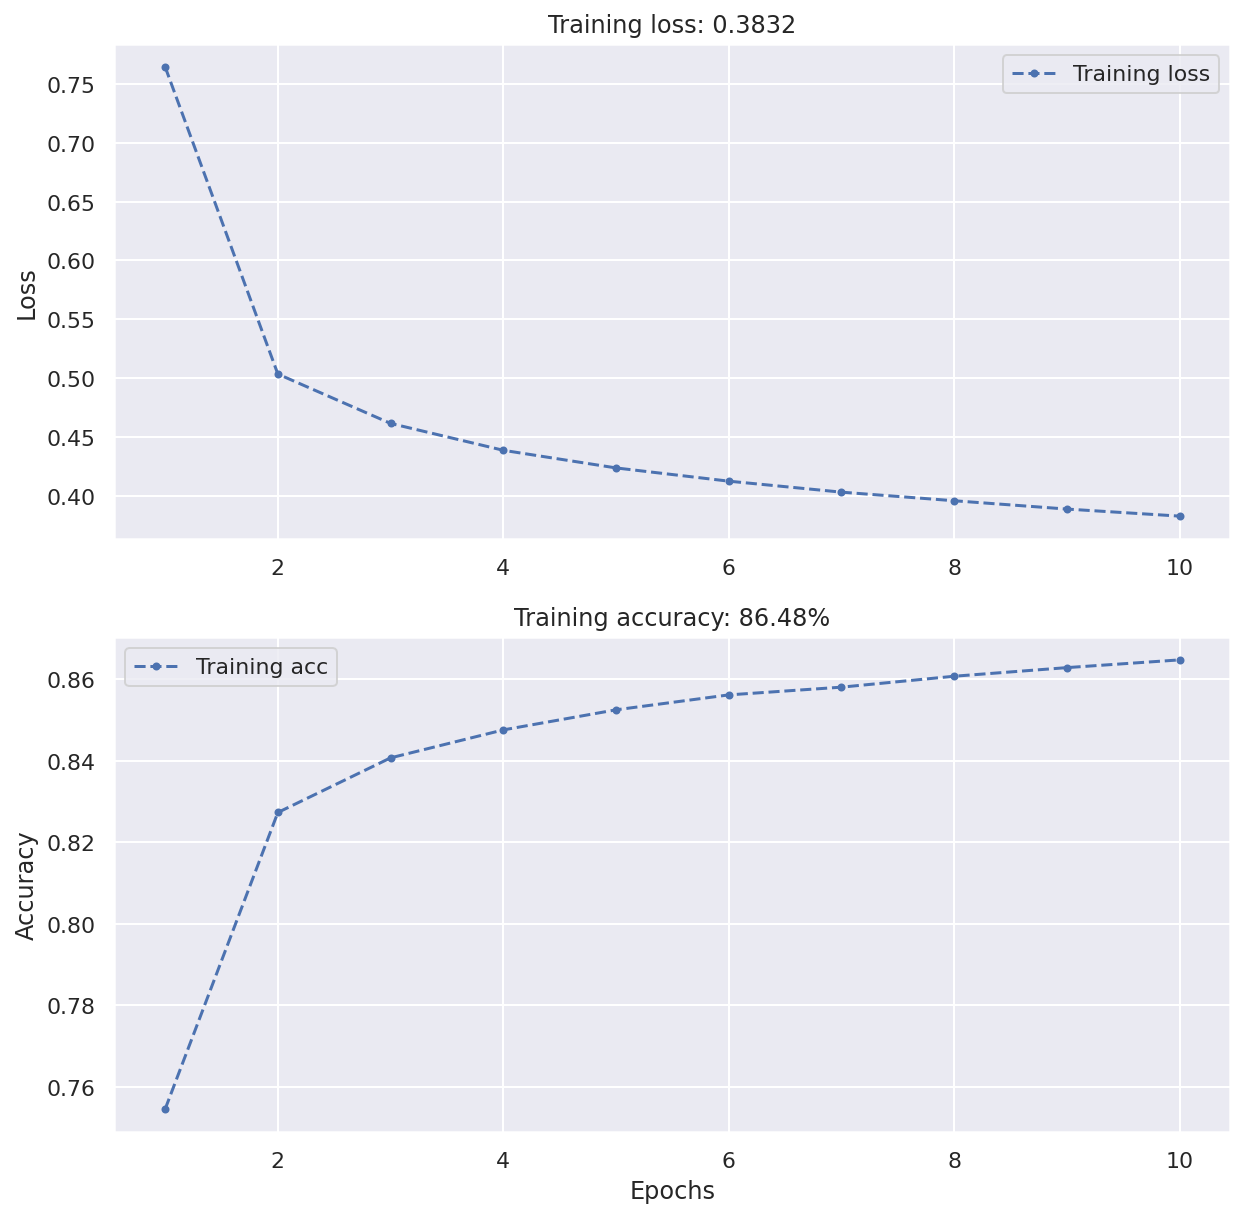

In [21]:
# Plot training history
plot_loss_acc(history)

In [22]:
# Evaluate the model on test data
_, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f'Test accuracy: {test_acc * 100:.2f}%')

assert test_acc > 0.84

Test accuracy: 84.87%


### Question

Show the first 10 test images with their predicted category ("dress", "shirt", etc).

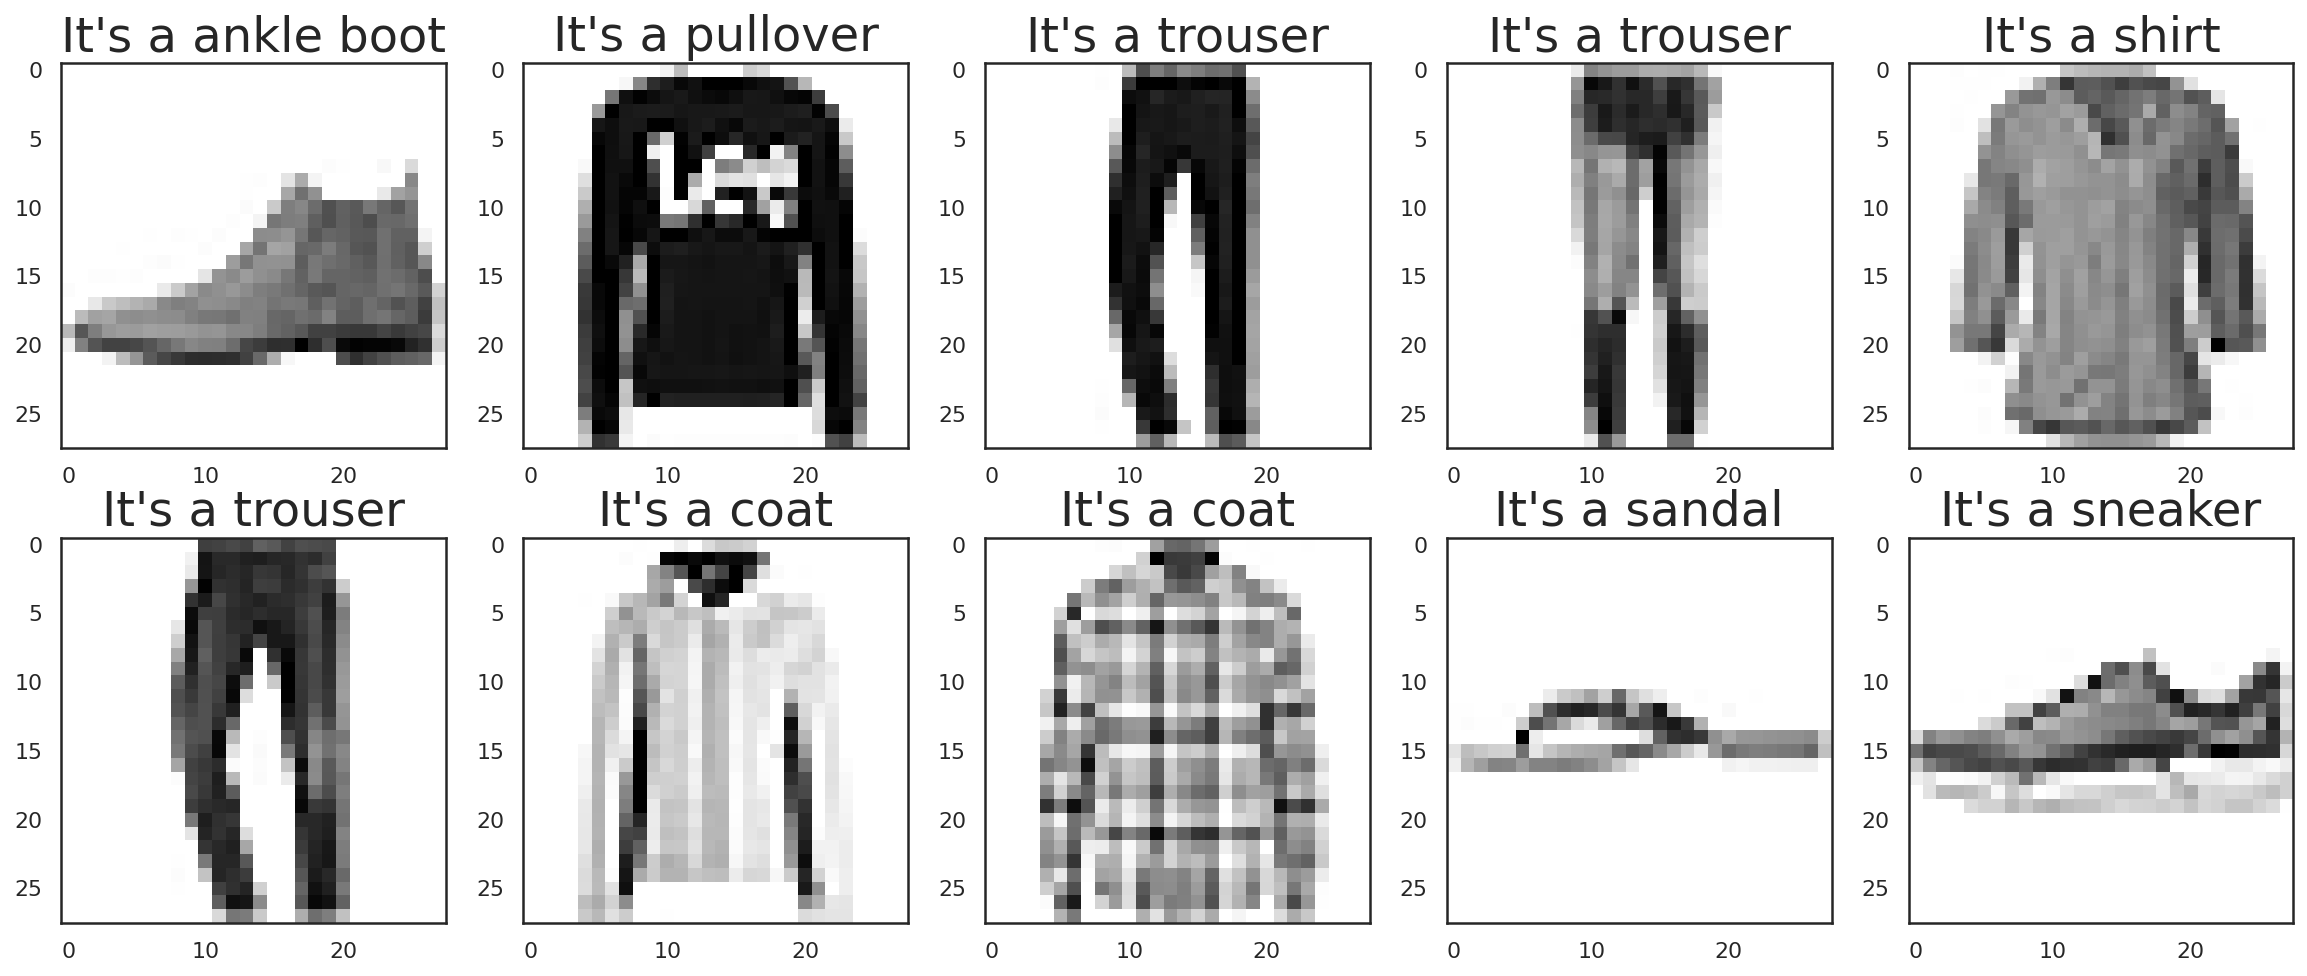

In [29]:
# Item descriptions, indexed by label value
descriptions = ['t-shirt', 'trouser', 'pullover', 'dress',
                'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# Plot the first 10 test digits with associated predictions

# Temporary hide Seaborn grid lines
with sns.axes_style("white"):
    plt.figure(figsize=(20, 8))
    for i in range(10):
        image = test_images[i]
        prediction = np.argmax(model.predict(image.reshape((1, 28, 28))))
        fig = plt.subplot(2, 5, i + 1)
        plt.title("It's a {}".format(descriptions[prediction]), fontsize=24)
        plt.imshow(image, cmap=plt.cm.binary)